<a href="https://colab.research.google.com/github/RGologorsky/fastmri/blob/master/02_kspace_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tackling Imagenette in Kspace

- Can a CNN learn to classify given kspace as input?
- Do data augs in kspace help?

## Setup

In [0]:
PROJ       = "fastmri"

In [2]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
from pathlib import Path 

ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # mount google drive at /content/drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
ALL_PROJ_PATH = Path(ROOT)/"My Drive/fastai_proj/"  # path to all projects 
PROJ_PATH   = ALL_PROJ_PATH/PROJ                    # path to project on PROJ
PROJ_PATH.mkdir(parents=True, exist_ok=True)        # make dir in PROJ to house Github

In [4]:
%run "$PROJ_PATH/common_constants_env.ipynb" # pip install fastai, fastmri, etc

pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
sys append /content/fastMRI
imports


In [0]:
%run "$PROJ_PATH/01_kspace_tfms.ipynb" # get the kspace tfms

## Data

In [0]:
path = untar_data(URLs.IMAGENETTE_160)
fnames = get_image_files(path)

In [12]:
fn_test = fnames[0]
fn_test

Path('/root/.fastai/data/imagenette2-160/val/n02102040/n02102040_4250.JPEG')

# Create dataset

1. raw items (fnames)
2. tfm list for x (BW Image)
3. tfm list for y (fn -> label dict -> Category)
4. training/valid split (by folder)

# Create dataloaders

- item-tfms: prepare for batching, tensors of uniform size (ToTensor, RandomResizedCrop)
- batch-tfms: data augs, TensorTfms.real2k, normalize


In [0]:
# convert filename stem to category
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [0]:
??T.ifft2

In [0]:
# take dataset item (real img, category), convert to (k arr, category)
class Real2K(Transform):
  order = 1
  def encodes(self, im:PILImageBW, permute=True):
    return apply(im, TensorTfms.real2k, pre=TensorTfms.im2arr)

# permute tensor: HW(Complex) to (Complex)HW
class Permute(Transform):
  order = 1
  def encodes(self, t:Tensor):
    if t.size(-1) == 2: return t.transpose(-1,-3).transpose(-1,-2)
    return t

  def decodes(self, t:Tensor):
    if t.size(-1) == 2: return t.transpose(-1,-2).transpose(-1,-3)
    return t

In [0]:
# define dataset
raw_items = fnames[0:20]
x_tfms = [PILImageBW.create]
y_tfms = [parent_label, lbl_dict.__getitem__, Categorize]

#splits = GrandparentSplitter(valid_name="val")(raw_items)
splits  = RandomSplitter(valid_pct=0.2, seed=42)(raw_items)

# define dataloaders
item_tfms  = [ToTensor, RandomResizedCrop(128, min_scale=0.35)]
batch_tfms = [Real2K, Permute] # Normalize? Real2K,

# define parameters
bs = 5
num_workers = 1

In [0]:
x = Pipeline([*x_tfms, *item_tfms, *batch_tfms])(fn_test)

In [213]:
x.shape

torch.Size([2, 128, 65])

In [0]:
xb = TfmdLists(raw_items, Pipeline([*x_tfms, *item_tfms, *batch_tfms]))

In [215]:
xb.train[0].shape

torch.Size([2, 128, 65])

In [0]:
xbt = torch.stack(tuple(xb.train), dim=0)

In [217]:
xbt.shape

torch.Size([20, 2, 128, 65])

In [218]:
splits

((#16) [1,10,0,4,6,11,8,3,7,17...], (#4) [2,14,18,15])

In [0]:
dsets = Datasets(raw_items, tfms = [x_tfms, y_tfms], splits=splits)

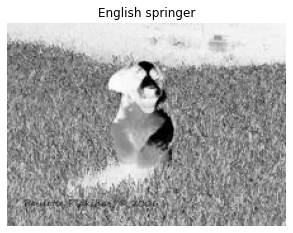

In [220]:
dsets.show(dsets[0])

In [0]:
dls = dsets.dataloaders(after_item = item_tfms, 
                        after_batch = batch_tfms, 
                        bs=bs, num_workers = num_workers)

In [222]:
dls.train_ds[0]

(PILImageBW mode=L size=191x160, TensorCategory(0))

In [0]:
xb,yb = dls.one_batch()

In [227]:
xb.shape

torch.Size([5, 1, 128, 128])

In [0]:
xbt = TfmdLists(xb, Pipeline([*batch_tfms]))

In [237]:
xb.shape

torch.Size([5, 1, 128, 128])

In [0]:
xb_double = tensor(xb).double()

In [239]:
type(xb_double), xb_double.shape

(fastai2.torch_core.TensorImageBW, torch.Size([5, 1, 128, 128]))

In [0]:
xb_fft = TensorTfms.rfft2(xb_double)

In [241]:
type(xb_fft), xb_fft.shape

(torch.Tensor, torch.Size([5, 1, 128, 65, 2]))

In [0]:
xb_shift = T.fftshift(xb_fft)

In [243]:
type(xb_shift), xb_shift.shape

(torch.Tensor, torch.Size([5, 1, 128, 65, 2]))

In [235]:
res = Real2K(xb)

RuntimeError: ignored

In [233]:
xbt.train[0].shape

torch.Size([1, 128, 128])

In [226]:
xbt.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

IndexError: ignored

In [224]:
xb.shape

torch.Size([5, 1, 128, 128])

In [158]:
%debug

> /usr/local/lib/python3.6/dist-packages/fastai2/torch_core.py(272)_f()
    270         def _f(self, *args, **kwargs):
    271             cls = self.__class__
--> 272             res = getattr(super(TensorBase, self), fn)(*args, **kwargs)
    273             return retain_type(res, self)
    274         return _f

ipdb> cls
<class 'fastai2.torch_core.TensorImageBW'>
ipdb> self
TensorImageBW([[[[174, 199, 205,  ...,  92, 129, 180],
          [163, 180, 197,  ...,  92,  97, 144],
          [130, 145, 181,  ...,  85,  91, 140],
          ...,
          [142, 148, 133,  ...,  90,  87,  86],
          [126, 137, 118,  ...,  85,  81,  80],
          [106, 107, 108,  ...,  92,  88,  88]]],


        [[[  2,   3,   2,  ...,   3,   3,   0],
          [  3,   6,   6,  ...,   0,   2,   1],
          [  2,   7,   2,  ...,   1,   2,   1],
          ...,
          [  2,   1,  15,  ...,  74,  81,  84],
          [  3,   3,  43,  ..., 118, 109, 120],
          [  0,   2,  31,  ...,  79,  79,  95]]],


In [0]:
dls.show_batch()

In [83]:
%debug

> /usr/local/lib/python3.6/dist-packages/fastcore/dispatch.py(98)__call__()
     96         if not f: return args[0]
     97         if self.inst is not None: f = MethodType(f, self.inst)
---> 98         return f(*args, **kwargs)
     99 
    100     def __get__(self, inst, owner):

ipdb> f
functools.partial(<built-in method rfft of type object at 0x7fdab863a300>, signal_ndim=2, normalized=True, onesided=True)
ipdb> args
self = (object,object) -> partial
args = (TensorImageBW([[[[  3,   3,   4,  ...,   6,   6,   6],
          [  3,   3,   3,  ...,   6,   6,   6],
          [  3,   3,   3,  ...,   7,   7,   7],
          ...,
          [ 31,  32,  34,  ..., 113, 111, 109],
          [ 31,  33,  35,  ..., 109, 107, 107],
          [ 30,  31,  33,  ..., 105, 104, 105]]],


        [[[ 83,  83,  83,  ...,  67,  69,  72],
          [ 84,  84,  84,  ...,  66,  68,  70],
          [ 85,  85,  85,  ...,  66,  68,  70],
          ...,
          [ 60,  60,  66,  ...,  36,  40,  38],
          [ 

English springer


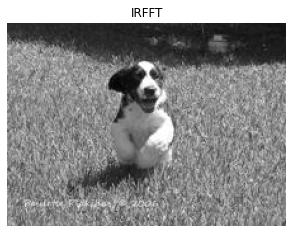

In [60]:
dsets.show(dsets[0])

# Dataloaders

- item-level tfms: Resize, ToTensor (so can be batched)
- batch-level tfms: Normalize, data aug

In [0]:
item_tfms = [ToTensor, RandomResizedCrop(128, min_scale=0.35)]
batch_tfms = [IntToFloatTensor, TensorTfms.real2k, Normalize()]

In [0]:
# given fn2attr dict, indexes into array of kspace slices
class KSliceTfm(Transform):
  def __init__(self, fn2attr_items, is_valid=False):
    self.fn2attr_items, self.is_valid = fn2attr_items, is_valid
    self.n_slices = [attr["n_slices"] for (_, attr) in self.fn2attr_items]
    self.cumsum = np.cumsum(self.n_slices)
    self.total_n_slices = self.cumsum[-1]

  def encodes(self, i) -> KS:
    fn2attr_idx  = np.searchsorted(self.cumsum, i)
    slice_idx = i - self.cumsum[fn2attr_idx]

    fname = self.fn2attr_items[fn2attr_idx][0]

    with h5py.File(fname, 'r') as data:
      kslice = data['kspace'][slice_idx]

    return KS(kslice)


## Convert imagenet to kspace in polar coord

In [0]:
def get_data(url, presize, resize):
  

# Old

In [0]:
# k tensor that knows how to show itself
class K():
  def __init__(self, k, orig_shape):
    self.k, self.orig_shape = k, orig_shape

  def show(self, ctx=None, **kwargs): 
    rev_img = apply(self.k, TensorTfms.k2real(self.orig_shape))
    show_image(rev_img, cmap = "gray", title = "IRFFT", ctx=ctx, **kwargs)

  def to_tensor(self): return self.k

In [0]:
# convert original img arr to k space
class KTfm(Transform):
  
  # store orig shape so it can be decoded correctly (for showing purposes)
  def encodes(self, arr)->Tensor:
    return K(apply(arr, TensorTfms.real2k), arr.shape)